# Reason for this file: Find out how to ammend the game-features

In [54]:
import numpy as np
import pickle
from sklearn import model_selection
import matplotlib.pyplot as plt

with open("my-saved-data.pt", "rb") as file:
    data_sample = pickle.load(file)
X_train, X_test, y_train, y_test = model_selection.train_test_split\
                                   (data_sample[:,:-1], data_sample[:,-1], test_size=.4, random_state=0)

First question: How bad are the rewards right now?

2250 203


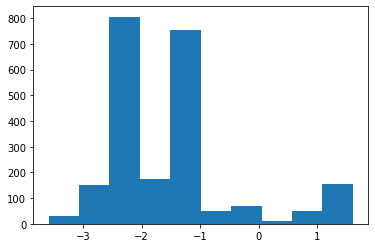

In [55]:
plt.hist(np.sort(y_train[np.abs(y_train) < 5]))
print(len(np.sort(y_train[np.abs(y_train) < 5])), len(np.sort(y_train[np.abs(y_train) >= 5]))) # Ausreißer-Verhältnis

-2.4692272938608832 4.4164537911596335 -19.9 6.692634798556833
-19.9 400.0


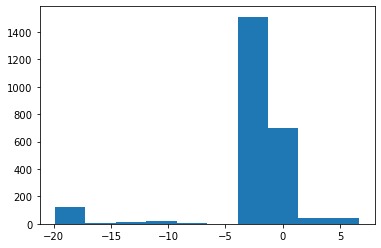

In [56]:
# noinspection LanguageDetectionInspection
plt.hist(np.sort(y_train))
print(np.mean(y_train), np.std(y_train), np.min(data_sample[:,-1]), np.max(data_sample[:,-1]))
print(np.min(data_sample), np.max(data_sample))

First answer: Most of the features are in between (-5, 5). That is actually not so bad. Question: How are we to deal with the (few) outliers?

Second question: Can we reduce matrix features?
How do we deal with missing data? Where does it come from?

In [52]:
X_mean = np.mean(X_train, axis = 0)
X_std = np.std(X_train, axis = 0)
X_centered = X_train - X_mean
np.max(X_train)

178.0

In [53]:
from sklearn import decomposition
M=200
X_train[(X_train == np.NaN).nonzero()] = 0
model = decomposition.NMF(n_components=M, init='random', random_state=0, max_iter=2000)
Z = model.fit_transform(X_train)
H = model.components_

ValueError: Negative values in data passed to NMF (input X)

In [57]:
with open("game_setup.pt", "rb") as file:
    game_sample = pickle.load(file)

In [72]:
print(game_sample["field"][1,3])
print(game_sample["field"].T)

0
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [-1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1]
 [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [-1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1]
 [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [-1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1]
 [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [-1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1]
 [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [-1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1]
 [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [-1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1]
 [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [-1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1  0 -1]
 [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
